# 랭체인(LangChain) Semi-structured RAG
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb

다양한 문서에는 **텍스트(text)와 표(tables)**를 포함한 혼합된 콘텐츠 유형이 포함되어 있습니다.

반구조적 데이터(Semi-structured data)는 적어도 두 가지 이유로 인해 기존의 RAG에 도전 과제를 제기할 수 있습니다:

*   텍스트 분할이 표를 분리하여 검색(retrieval) 시 데이터가 손상될 수 있습니다.
*   표를 임베딩하는 것은 의미적 유사성 검색(semantic similarity search)에 어려움을 초래할 수 있습니다.

이 예제는 반구조적 데이터(Semi-structured data)가 포함된 문서에서 RAG를 수행하는 방법을 보여줍니다:

*   우리는 **Unstructured( https://unstructured.io/ )를 사용하여 문서(PDF)에서 텍스트와 표를 모두 파싱**할 것입니다.
*   우리는 MultiVectorRetriever를 사용하여 **원본 표(raw tables), 텍스트(text)와 함께 요약된 표(table summaries)를 저장**하여 검색에 더 적합하게 할 것입니다.
*   우리는 LCEL을 사용하여 사용될 체인을 구현할 것입니다.

전체 흐름은 다음과 같습니다

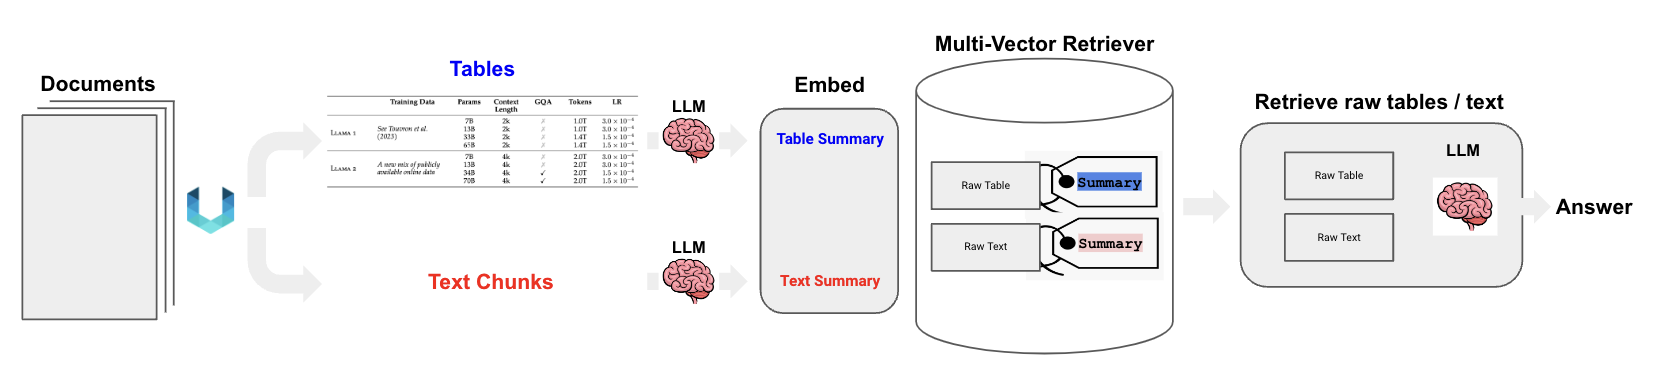

# LangChain 및 필요한 라이브러리 설치

In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml langchain_openai langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 42.0 

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (361 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121965 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install pytesseract

Unstructured에서 PDF 분할을 위해 다음을 사용합니다:

*   OCR(광학 문자 인식)을 위한 Tesseract
*   PDF 렌더링 및 처리를 위한 Poppler

# OpenAI API Key 설정

In [ ]:
OPENAI_KEY = "여러분의_OPENAI_API_KEY"

# Data Loading

## PDF 표(Tables)와 텍스트(text) 분할

LLaVA 논문에 적용하기

Unstructured의 **partition_pdf**를 사용하여 레이아웃 모델을 이용해 PDF 문서를 세분화합니다.

이 레이아웃 모델을 통해 PDF에서 표와 같은 요소를 추출할 수 있습니다.

또한, Unstructured의 청킹(chunking)을 사용할 수 있으며, 이는:

*   문서의 섹션(예: introduction 등)을 식별하려고 시도한 후,
*   섹션을 유지하면서 사용자 정의 청크 크기를 준수하는 텍스트 블록을 생성합니다.



*   LLaVA Paper: https://arxiv.org/pdf/2304.08485.pdf


In [ ]:
path = './'

In [ ]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "LLaVA.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


partition_pdf로 추출된 요소를 확인할 수 있습니다.

CompositeElement는 집계된 청크입니다.

In [ ]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 4}

In [ ]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

4
31


In [ ]:
table_elements

[Element(type='table', text='Conversation Detail description Complex reasoning All Full data Detail + Complex Conv + 5% Detail + 10% Complex Conversation No Instruction Tuning 83.1 81.5 (-1.6) 81.0 (-2.1) 76.5 (-6.6) 22.0 (-61.1) 75.3 73.3 (-2.0) 68.4 (-7.1) 59.8 (-16.2) 24.0 (-51.3) 96.5 90.8 (-5.7) 91.5 (-5.0) 84.9 (-12.4) 18.5 (-78.0) 85.1 81.9 (-3.2) 80.5 (-4.4) 73.8 (-11.3) 21.5 (-63.6)'),
 Element(type='table', text='Conversation Detail description Complex reasoning All OpenFlamingo [5] BLIP-2 [28] LLaVA LLaVA† 19.3 ± 0.5 54.6 ± 1.4 57.3 ± 1.9 58.8 ± 0.6 19.0 ± 0.5 29.1 ± 1.2 52.5 ± 6.3 49.2 ± 0.8 19.1 ± 0.7 32.9 ± 0.7 81.7 ± 1.8 81.4 ± 0.3 19.1 ± 0.4 38.1 ± 1.0 67.3 ± 2.0 66.7 ± 0.3'),
 Element(type='table', text='Method NAT Subject SOC LAN Context Modality IMG TXT NO Grade G1-6 G7-12 Average Representative & SoTA methods with numbers reported in the literature 90.23 Human [34] 74.64 GPT-3.5 [34] 75.44 GPT-3.5 w/ CoT [34] 84.37 LLaMA-Adapter [59] 87.52 MM-CoTBase [61] MM-CoTLarg

In [ ]:
text_elements

[Element(type='text', text='3 2 0 2 c e D 1 1\n\n] V C . s c [ 2 v 5 8 4 8 0 . 4 0 3 2 : v i X r a\n\nVisual Instruction Tuning\n\nHaotian Liu1∗, Chunyuan Li2∗, Qingyang Wu3, Yong Jae Lee1\n\n1University of Wisconsin–Madison 2Microsoft Research 3Columbia University https://llava-vl.github.io\n\nAbstract\n\nInstruction tuning large language models (LLMs) using machine-generated instruction-following data has been shown to improve zero-shot capabilities on new tasks, but the idea is less explored in the multimodal field. We present the first attempt to use language-only GPT-4 to generate multimodal language-image instruction-following data. By instruction tuning on such generated data, we in- troduce LLaVA: Large Language and Vision Assistant, an end-to-end trained large multimodal model that connects a vision encoder and an LLM for general- purpose visual and language understanding. To facilitate future research on visual instruction following, we construct two evaluation benchmarks wit

# Multi-vector retriever

multi-vector-retriever를 사용하여 표와 선택적으로 **텍스트의 요약(summaries)을 생성**합니다.

요약과 함께 원본 표 요소(raw tables)도 저장합니다.

**요약은 검색의 품질을 향상시키는 데 사용**되며, 이는 multi-vector retriever 공식문서에서 설명됩니다.

**원본 표는 LLM에 전달되어, LLM이 답변을 생성하는 데 전체 표 맥락을 제**공합니다.











# Summaries

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

각 요소에 대해 간단한 요약 체인을 생성합니다.

In [ ]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element}"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4", openai_api_key=OPENAI_KEY)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
table_summaries

['The table presents data on conversation detail description and complex reasoning. The data is divided into five categories: Full data, Detail + Complex Conv + 5%, Detail + 10% Complex, Conversation, and No Instruction Tuning. In all categories, there is a decrease in values as the complexity increases. The most significant decrease is observed in the No Instruction Tuning category, with drops ranging from -51.3 to -78.0. The smallest decrease is seen in the Full data category, with drops ranging from -1.6 to -6.6.',
 'The table presents the performance of different models (OpenFlamingo, BLIP-2, LLaVA, and LLaVA†) in terms of complex reasoning in conversation detail description. The results are presented as percentages with a margin of error. LLaVA† shows the highest performance in all categories, with scores ranging from 58.8 ± 0.6 to 81.4 ± 0.3. OpenFlamingo consistently scores the lowest, with results ranging from 19.0 ± 0.5 to 19.3 ± 0.5.',
 "The table presents the performance of 

In [ ]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})

In [ ]:
text_summaries

['The text discusses a study on instruction tuning large language models (LLMs) using machine-generated instruction-following data to improve zero-shot capabilities on new tasks. The researchers used language-only GPT-4 to generate multimodal language-image instruction-following data. They introduced LLaVA: Large Language and Vision Assistant, a large multimodal model trained end-to-end that connects a vision encoder and an LLM for general-purpose visual and language understanding. They also constructed two evaluation benchmarks for future research on visual instruction following. The experiments showed that LLaVA demonstrated impressive multimodal chat abilities and achieved a new state-of-the-art accuracy of 92.53% when fine-tuned on Science QA. The researchers made GPT-4 generated visual instruction tuning data, their model, and code publicly available.',
 'The text discusses the development of artificial intelligence, specifically focusing on creating a general-purpose assistant th

# Add to vectorstore

요약과 함께 Multi Vector Retriever를 사용하세요:

*   InMemoryStore는 원본 텍스트와 표를 저장합니다.
*   vectorstore는 임베딩된 요약을 저장합니다.

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings(openai_api_key=OPENAI_KEY))

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# RAG

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(temperature=0, model="gpt-4", openai_api_key=OPENAI_KEY)

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke("What is the performance of the GPT-4 model on the Science QA dataset?")

'The GPT-4 model achieves 82.69% accuracy on the Science QA dataset. When used in combination with the LLaVA model, the accuracy increases. Specifically, when GPT-4 is used as a complement (providing answers when GPT-4 fails), the accuracy is 90.97%. When GPT-4 is used as a judge (providing a final answer when GPT-4 and LLaVA produce different answers), the accuracy further increases to 92.53%.'